# Экзогенные переменные

## Импорт модулей

In [1]:
import numpy as np
import pandas as pd

from fbprophet import Prophet

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline
plt.rcParams["figure.figsize"] = (12,5)

## Данные

In [2]:
mtuk = pd.read_excel("mean_temperature_UK.xlsx", index_col="Date", parse_dates=True)

In [3]:
uk = pd.read_csv("UnitedKingdom.csv", index_col="Date", parse_dates=True)

In [4]:
uk

,Gas consumption,UGS storage,LNG send out
Date,,,
2014-01-01,NaN,0.178547,612.923160
2014-01-02,NaN,0.188001,609.684587
2014-01-03,NaN,0.193733,606.439351
2014-01-04,NaN,0.193733,603.194115
2014-01-05,NaN,0.189011,599.962206
...,...,...,...
2020-12-27,254.908453,1.454552,515.132932
2020-12-28,329.111672,1.407907,590.799578
2020-12-29,328.514920,1.372570,550.150829


In [5]:
mtuk = mtuk.loc[(mtuk.index > "2013-12-31") & (mtuk.index < "2021-01-01")]

In [6]:
data = pd.concat([uk[["UGS storage"]], mtuk], axis=1)

In [7]:
data.head()

,UGS storage,GB
Date,,
2014-01-01,0.178547,7.06
2014-01-02,0.188001,7.46
2014-01-03,0.193733,7.55
2014-01-04,0.193733,5.52
2014-01-05,0.189011,5.86


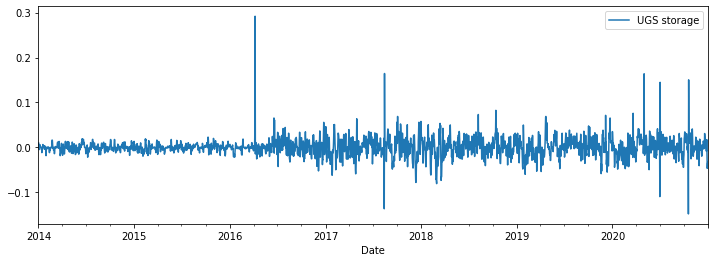

In [8]:
data[["UGS storage"]].diff(1).plot(figsize=(12,4))
plt.show()

## Убираем выбросы

In [9]:
df = data[["UGS storage"]].diff(1).dropna()

In [10]:
quantile_up, quantile_low = np.percentile(df["UGS storage"], [99, 1], interpolation="midpoint")

In [11]:
df

,UGS storage
Date,
2014-01-02,0.009453
2014-01-03,0.005732
2014-01-04,0.000000
2014-01-05,-0.004722
2014-01-06,0.002351
...,...
2020-12-27,-0.011134
2020-12-28,-0.046646
2020-12-29,-0.035336


In [12]:
df["UGS storage"].loc[(df["UGS storage"] > quantile_up) | (df["UGS storage"] < quantile_low)]

Date
2016-04-07    0.291814
2016-06-18    0.065455
2016-06-20    0.061112
2016-12-05   -0.052320
2016-12-25    0.055749
2017-01-26   -0.061977
2017-01-27   -0.053622
2017-04-26   -0.058810
2017-04-30    0.063716
2017-08-13   -0.136546
2017-08-14    0.164440
2017-10-01    0.056303
2017-10-03    0.068875
2017-10-14    0.052222
2017-12-11   -0.073131
2017-12-12   -0.077969
2017-12-13   -0.062162
2017-12-23    0.055837
2017-12-24    0.055536
2017-12-25    0.054632
2017-12-30    0.051591
2017-12-31    0.057780
2018-02-06   -0.058926
2018-02-07   -0.061491
2018-02-26   -0.070546
2018-02-27   -0.069623
2018-02-28   -0.076298
2018-03-01   -0.080631
2018-03-02   -0.050989
2018-03-14    0.053408
2018-03-18   -0.073393
2018-03-19   -0.065757
2018-03-20   -0.065008
2018-08-07    0.073209
2018-10-13    0.082468
2019-02-02   -0.059937
2019-03-18   -0.052980
2019-04-04   -0.053602
2019-04-21    0.067165
2019-04-22    0.068866
2019-04-26    0.054719
2019-11-19   -0.058343
2019-11-21   -0.052650
2019-1

In [13]:
df["UGS storage"] = df["UGS storage"].interpolate(method="linear")

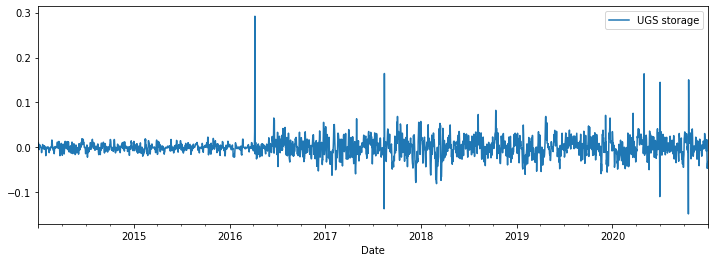

In [14]:
df.plot(figsize=(12,4))
plt.show()

## Prophet

In [53]:
mtuk_future = pd.read_excel("mean_temperature_UK.xlsx", index_col="Date", parse_dates=True)
mtuk_future = mtuk_future.loc[mtuk_future.index > "2015-12-31"].reset_index()

In [43]:
data_prophet = pd.concat([df.loc[df.index > "2015-12-31"][["UGS storage"]], mtuk.loc[mtuk.index > "2015-12-31"]], axis=1)
data_prophet = data_prophet.reset_index()
data_prophet.columns = ['ds', 'y', 'exog']

In [45]:
data_prophet.tail()

,ds,y,exog
1822,2020-12-27,-0.011134,4.22
1823,2020-12-28,-0.046646,2.62
1824,2020-12-29,-0.035336,3.06
1825,2020-12-30,-0.032810,1.95
1826,2020-12-31,-0.033947,1.94


In [39]:
data_prophet = data_prophet[data_prophet['exog'].notna()]

In [40]:
model = Prophet(weekly_seasonality=False, daily_seasonality=False)
model.add_regressor('exog')
model.fit(data_prophet)

In [55]:
future = model.make_future_dataframe(periods=312, freq='D')
future['exog'] = mtuk_future["GB"]
forecast = model.predict(future)

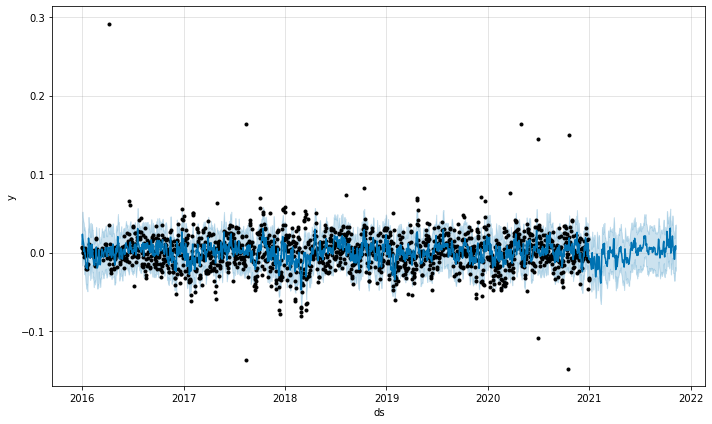

In [57]:
model.plot(forecast)
plt.show()